<a href="https://colab.research.google.com/github/HaeRin-OortCloud/AI-Lab/blob/main/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Model Import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets 

In [ ]:
# Device Check
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

BATCH_SIZE = 32
EPOCHS = 10

Using PyTorch version: 1.13.0+cu116  Device: cpu


In [ ]:
# CHIFAR10 Data Download
## Data Augmentation

train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5),
                                                          (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))]))


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [ ]:
# Data Check(1)
for (x_train, y_train) in train_loader:
  print('x_train:', x_train.size(), 'type:', x_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

x_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


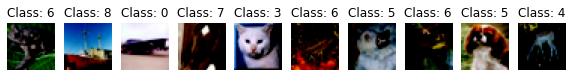

In [ ]:
# Data Check(2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(np.transpose(x_train[i], (1, 2, 0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
# CNN Model Design
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels = 3,
        out_channels = 8,
        kernel_size = 3,
        padding = 1)
    self.conv2 = nn.Conv2d(
        in_channels = 8,
        out_channels = 16,
        kernel_size = 3,
        padding = 1)
    self.pool = nn.MaxPool2d(
        kernel_size = 2,
        stride = 2)
    self.fc1 = nn.Linear(8 * 8 * 16, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)

    x = x.view(-1, 8 * 8 * 16)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.log_softmax(x)
    return x

In [ ]:
# Optimizer, Objective Function
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion  = nn.CrossEntropyLoss()
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
# def Train + Performance Check
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx * len(image), 
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

In [ ]:
# def Evaluate + Performance Check
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [ ]:
# Final
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".
        format(Epoch, test_loss, test_accuracy))

<ipython-input-56-aff66eb2572d>:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.296898
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.862311
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.625151
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.365252
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.588125
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.559694
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.533729
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 0.980413

[EPOCH: 1], 	Test Loss: 0.0413, 	Test Accuracy: 51.94 % 

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.133887
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.297224
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.296448
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.673749
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.562209
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.021826
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.036383
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.020132

[EPOCH: 2], 	Test Loss: 0.0365, 	Test Accuracy: 58.59 % 

Train Epoch: 3